<a href="https://colab.research.google.com/github/Joaquin-Estevez/CAP4770/blob/main/Predicting_Football_Match_Outcomes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Required Libraries

In [1]:
!pip install pandas numpy scikit-learn matplotlib seaborn xgboost

# Load and Preprocess the Data

In [8]:
# Import libraries
import kagglehub
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
# Step 1: Load Dataset
path = kagglehub.dataset_download("martj42/international-football-results-from-1872-to-2017")
print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/martj42/international-football-results-from-1872-to-2017/versions/89


In [10]:
# Load CSV files
results = pd.read_csv(f"{path}/results.csv")
shootouts = pd.read_csv(f"{path}/shootouts.csv")
goalscorers = pd.read_csv(f"{path}/goalscorers.csv")

In [11]:
# Convert dates to datetime for merging
results['date'] = pd.to_datetime(results['date'])
shootouts['date'] = pd.to_datetime(shootouts['date'])
goalscorers['date'] = pd.to_datetime(goalscorers['date'])

In [12]:
# Merge datasets
results_with_shootouts = pd.merge(results, shootouts, how='left', on=['date', 'home_team', 'away_team'])
full_data = pd.merge(results_with_shootouts, goalscorers, how='left', on=['date', 'home_team', 'away_team'])

In [13]:
# Step 2: Feature Engineering
# Add a 'result' column: win, draw, or loss for the home team
def match_outcome(row):
    if row['home_score'] > row['away_score']:
        return 'Win'
    elif row['home_score'] < row['away_score']:
        return 'Loss'
    else:
        return 'Draw'

full_data['result'] = full_data.apply(match_outcome, axis=1)

In [14]:
# Encode categorical columns
le_tournament = LabelEncoder()
full_data['tournament_encoded'] = le_tournament.fit_transform(full_data['tournament'])

le_home_team = LabelEncoder()
full_data['home_team_encoded'] = le_home_team.fit_transform(full_data['home_team'])

le_away_team = LabelEncoder()
full_data['away_team_encoded'] = le_away_team.fit_transform(full_data['away_team'])

In [15]:
# Select relevant columns for training
features = [
    'home_team_encoded',
    'away_team_encoded',
    'neutral',
    'tournament_encoded',
    'home_score',
    'away_score'
]
target = 'result'

In [16]:
# Drop rows with missing target
data = full_data.dropna(subset=[target])

In [18]:
#Encode the target variable
le_result = LabelEncoder()
data['result_encoded'] = le_result.fit_transform(data[target])

In [19]:
# Step 3: Data Splitting
X = data[features]
y = data['result_encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [20]:
# Step 4: Model Training
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [21]:
# Step 5: Model Evaluation
y_pred = model.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le_result.classes_))


Classification Report:
              precision    recall  f1-score   support

        Draw       1.00      1.00      1.00      2926
        Loss       1.00      1.00      1.00      4530
         Win       1.00      1.00      1.00      8125

    accuracy                           1.00     15581
   macro avg       1.00      1.00      1.00     15581
weighted avg       1.00      1.00      1.00     15581



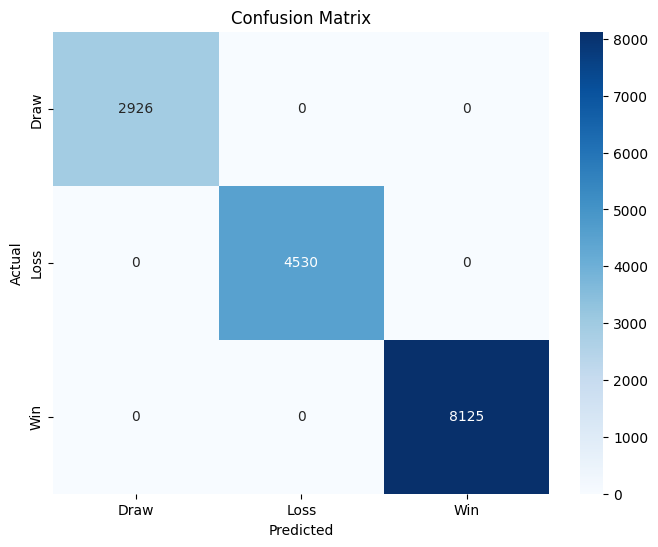

In [22]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le_result.classes_, yticklabels=le_result.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

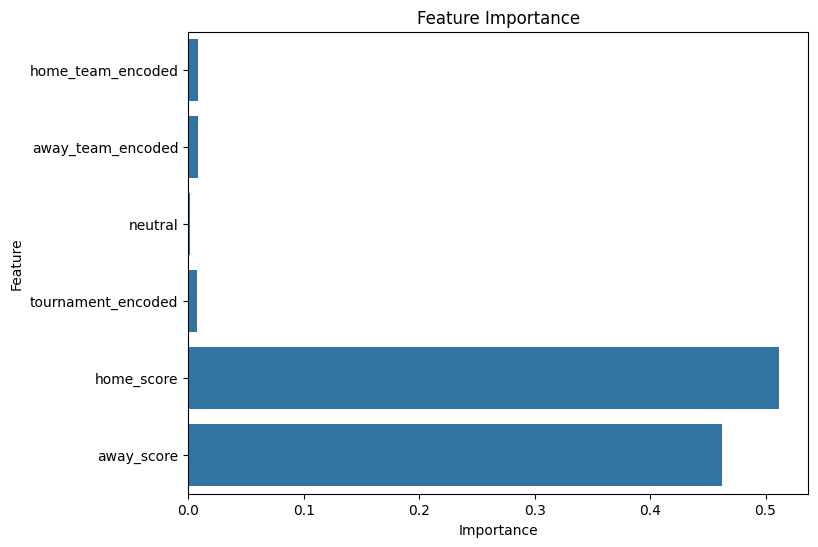

In [23]:
# Step 6: Feature Importance
importance = model.feature_importances_
plt.figure(figsize=(8, 6))
sns.barplot(x=importance, y=features)
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

In [24]:
# Final Output
print("Top 5 Rows of Processed Data:")
print(data[features + [target]].head())

Top 5 Rows of Processed Data:
   home_team_encoded  away_team_encoded  neutral  tournament_encoded  \
0                250                 89    False                  85   
1                 88                244    False                  85   
2                250                 89    False                  85   
3                 88                244    False                  85   
4                250                 89    False                  85   

   home_score  away_score result  
0           0           0   Draw  
1           4           2    Win  
2           2           1    Win  
3           2           2   Draw  
4           3           0    Win  
